# Importing Libraries

In [1]:
from mimic.mimic import MIMIC, MIMICManipulations

In [2]:
from utils.util import generic_utils

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load Data

In [4]:
df = pd.read_csv('./dataset/ch_03_dataset.csv')
df.head()

,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,hospital_expire_flag,los_admission,gender,...,flag,priority,drg_type,drg_code,drug,route,org_name,test_name,ab_name,curr_service
0,ELECTIVE,Other,HOME,Other,ENGLISH,Other,WHITE,0.0,1.968056,M,...,normal,STAT,HCFA,795.0,Other,IM,None,"Blood Culture, Routine",None,NB
1,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,0.0,2.222222,F,...,abnormal,ROUTINE,HCFA,442.0,Influenza Vaccine Quadrivalent,IM,None,Other,None,MED
2,ELECTIVE,Other,HOME,Other,ENGLISH,Other,ASIAN,0.0,1.865278,F,...,normal,STAT,HCFA,795.0,Erythromycin 0.5% Ophth Oint,BOTH EYES,None,Other,None,NB
3,EU OBSERVATION,EMERGENCY ROOM,Other,Other,ENGLISH,SINGLE,WHITE,0.0,0.298611,F,...,normal,OTHER,OTHER,0.0,None,None,None,None,None,MED
4,ELECTIVE,Other,HOME,Other,ENGLISH,Other,WHITE,0.0,4.109722,M,...,normal,STAT,HCFA,795.0,Erythromycin 0.5% Ophth Oint,BOTH EYES,None,None,None,NB


In [5]:
df.flag.value_counts()

normal      227037
abnormal     29759
Name: flag, dtype: int64

In [6]:
df.test_name.value_counts()

None                        83079
URINE CULTURE               58901
Blood Culture, Routine      34109
Other                       27219
MRSA SCREEN                 23028
Blood Culture, Neonate      11207
WOUND CULTURE                6335
Staph aureus Screen          4438
RAPID PLASMA REAGIN TEST     3576
GRAM STAIN                   2815
FLUID CULTURE                2089
Name: test_name, dtype: int64

In [7]:
df.curr_service.value_counts()

MED      88405
NB       59972
SURG     17386
CMED     15344
ORTHO    13681
OBS      10748
NMED     10447
NSURG     7448
CSURG     5621
TRAUM     5071
OMED      4948
VSURG     3452
GYN       3336
PSYCH     2545
PSURG     2534
GU        2415
TSURG     2019
Other     1424
Name: curr_service, dtype: int64

In [8]:
#For binary classification, use flag and for multi class classification use current service

In [9]:
df.loc[df['flag'] == 'normal', 'flag'] = '1'
df.loc[df['flag'] == 'abnormal', 'flag'] = '0'

In [10]:
df.flag.value_counts()

1    227037
0     29759
Name: flag, dtype: int64

In [11]:
df.flag = df.flag.astype('int64')

In [12]:
df.flag.dtype

dtype('int64')

# Transformation Pipelines

In [13]:
for column in df.columns:
    if column in ['hospital_expire_flag', 'los_admission', 'anchor_age', 'drg_code']:
        try:
            df[column] = df[column].astype('float64')
        except Exception as ex:
            pass
    else:
        df[column] = df[column].astype('string')

In [14]:
categorical_columns = df.select_dtypes(include=['string']).columns.tolist()

In [15]:
categorical_columns.remove('flag')

In [16]:
numerical_columns = [df.select_dtypes(exclude=['string']).columns.tolist()[2]]
numerical_columns

['anchor_age']

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer


In [18]:
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

In [19]:

num_attribs = numerical_columns
cat_attribs = categorical_columns

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OrdinalEncoder(), cat_attribs),
    ])

# Create Test Set

In [20]:
np.random.seed(42)

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["flag"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [22]:
train_set_X = strat_train_set.drop("flag", axis = 1)
train_set_y = strat_train_set["flag"]

test_set_X = strat_test_set.drop("flag", axis = 1)
test_set_y = strat_test_set["flag"]

In [23]:
train_set_X_prepared = full_pipeline.fit_transform(train_set_X)

In [24]:
train_set_X_prepared.shape

(205436, 18)

In [25]:
type(train_set_X_prepared)

numpy.ndarray

In [26]:
train_set_X_prepared

array([[ 0.39909861,  2.        ,  4.        , ...,  6.        ,
         4.        ,  4.        ],
       [-0.11151772,  7.        ,  4.        , ...,  9.        ,
         0.        ,  6.        ],
       [-1.43912018,  3.        ,  2.        , ...,  5.        ,
         4.        ,  5.        ],
       ...,
       [-1.43912018,  3.        ,  2.        , ...,  5.        ,
         4.        ,  5.        ],
       [ 0.50122187,  5.        ,  1.        , ...,  6.        ,
         4.        ,  0.        ],
       [ 1.35224909,  4.        ,  1.        , ...,  1.        ,
         4.        ,  4.        ]])

In [27]:
X_test_prepared = full_pipeline.transform(test_set_X)

In [28]:
train_set_y = train_set_y.to_numpy()
train_set_y

array(['1', '1', '1', ..., '1', '1', '1'], dtype=object)

In [29]:
test_set_y = test_set_y.to_numpy()
test_set_y

array(['1', '1', '1', ..., '1', '1', '1'], dtype=object)

# Training a Binary Classifier

In [30]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(train_set_X_prepared, train_set_y)

SGDClassifier(random_state=42)

In [31]:
sgd_clf.predict([train_set_X_prepared[2]])

array(['1'], dtype='<U1')

In [32]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, train_set_X_prepared, train_set_y, cv=3, scoring="accuracy")

array([0.88411046, 0.88411046, 0.88412337])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(train_set_X_prepared, train_set_y):
    clone_clf = clone(sgd_clf)
    X_train_folds = train_set_X_prepared[train_index]
    y_train_folds = train_set_y[train_index]
    X_test_fold = train_set_X_prepared[test_index]
    y_test_fold = train_set_y[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.8841104572204618
0.8841104572204618
0.8841233680890213


## Confusion Matrix

In [34]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, train_set_X_prepared, train_set_y, cv=3)

In [35]:
from sklearn.metrics import confusion_matrix

confusion_matrix(train_set_y, y_train_pred)

array([[     1,  23806],
       [     1, 181628]])

## Precision and Recall

In [36]:
from sklearn.metrics import precision_score, recall_score

precision_score(train_set_y, y_train_pred, pos_label="1")

0.8841185003456098

In [37]:
cm = confusion_matrix(train_set_y, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8841185003456098

In [38]:
recall_score(train_set_y, y_train_pred, pos_label="1")

0.9999944942712893

In [39]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.9999944942712893

In [40]:
from sklearn.metrics import f1_score

f1_score(train_set_y, y_train_pred, pos_label="1")

0.938493216866505

In [41]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.9384932168665049

## Precision/Recall Trade-off

In [42]:
y_scores = sgd_clf.decision_function([train_set_X_prepared[546]])
y_scores

array([0.97163006])

In [43]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [44]:
y_some_digit_pred

array([ True])

In [45]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [46]:
y_scores = cross_val_predict(sgd_clf, train_set_X_prepared, train_set_y, cv=3,
                             method="decision_function")

In [47]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(train_set_y, y_scores, pos_label='1')

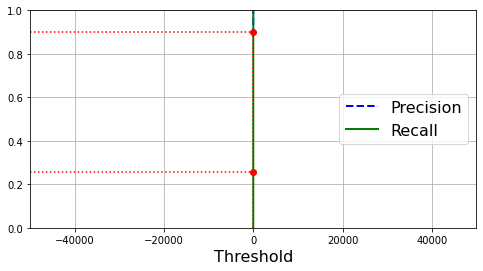

In [48]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
#save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [49]:
(y_train_pred == (y_scores > 0))

/tmp/ipykernel_1674/1146860681.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (y_train_pred == (y_scores > 0))


False

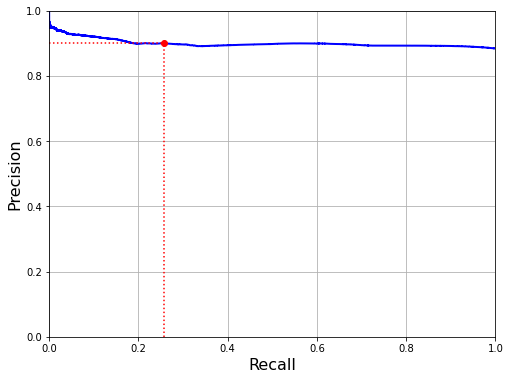

In [50]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

In [51]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [52]:
threshold_90_precision

1.4165053991977394

In [53]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90 = y_train_pred_90.astype('int')
y_train_90 = []
for item in y_train_pred_90:
    if item == 1:
        y_train_90.append('1')
    elif item == 0:
        y_train_90.append('0')

In [54]:
precision_score(train_set_y, y_train_90, pos_label='1')

0.9

In [55]:
recall_score(train_set_y, y_train_90, pos_label='1')

0.2563797631435509

## The ROC Curve

In [56]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(train_set_y, y_scores, pos_label='1')

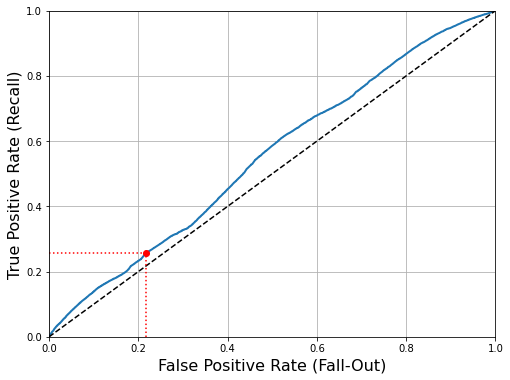

In [57]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
#save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [58]:
from sklearn.metrics import roc_auc_score

roc_auc_score(train_set_y, y_scores)

0.550572925419654

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

In [59]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, train_set_X_prepared, train_set_y, cv=3,
                                    method="predict_proba")

In [60]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(train_set_y,y_scores_forest, pos_label='1')

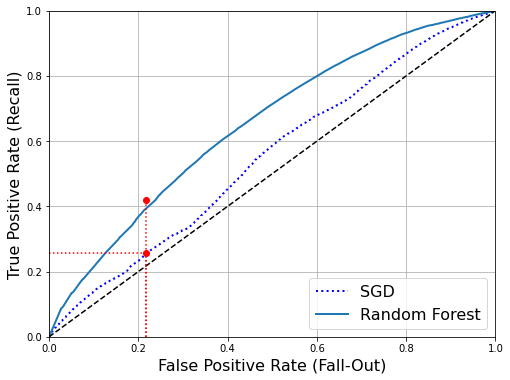

In [61]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

In [62]:
roc_auc_score(train_set_y, y_scores_forest)

0.6513689581630975

In [63]:
y_train_pred_forest = cross_val_predict(forest_clf, train_set_X_prepared, train_set_y, cv=3)
precision_score(train_set_y, y_train_pred_forest, pos_label='1')

0.8871488385658426

In [64]:
recall_score(train_set_y, y_train_pred_forest, pos_label='1')

0.9880800973412837

# Multiclass Classification

In [65]:
from sklearn.preprocessing import LabelEncoder

In [66]:
le = LabelEncoder()

In [67]:
df.curr_service = le.fit_transform(df.curr_service)

In [68]:
df.head()

,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,hospital_expire_flag,los_admission,gender,...,flag,priority,drg_type,drg_code,drug,route,org_name,test_name,ab_name,curr_service
0,ELECTIVE,Other,HOME,Other,ENGLISH,Other,WHITE,0.0,1.968056,M,...,1,STAT,HCFA,795.0,Other,IM,None,"Blood Culture, Routine",None,5
1,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,0.0,2.222222,F,...,0,ROUTINE,HCFA,442.0,Influenza Vaccine Quadrivalent,IM,None,Other,None,4
2,ELECTIVE,Other,HOME,Other,ENGLISH,Other,ASIAN,0.0,1.865278,F,...,1,STAT,HCFA,795.0,Erythromycin 0.5% Ophth Oint,BOTH EYES,None,Other,None,5
3,EU OBSERVATION,EMERGENCY ROOM,Other,Other,ENGLISH,SINGLE,WHITE,0.0,0.298611,F,...,1,OTHER,OTHER,0.0,None,None,None,None,None,4
4,ELECTIVE,Other,HOME,Other,ENGLISH,Other,WHITE,0.0,4.109722,M,...,1,STAT,HCFA,795.0,Erythromycin 0.5% Ophth Oint,BOTH EYES,None,None,None,5


In [69]:
df.curr_service.value_counts()

4     88405
5     59972
14    17386
0     15344
10    13681
8     10748
6     10447
7      7448
1      5621
15     5071
9      4948
17     3452
3      3336
13     2545
12     2534
2      2415
16     2019
11     1424
Name: curr_service, dtype: int64

In [70]:
categorical_columns = df.select_dtypes(include=['string']).columns.tolist()
#categorical_columns.remove('curr_service')
categorical_columns

['admission_type',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'ethnicity',
 'gender',
 'eventtype',
 'flag',
 'priority',
 'drg_type',
 'drug',
 'route',
 'org_name',
 'test_name',
 'ab_name']

In [71]:
numerical_columns = df.select_dtypes(exclude=['string']).columns.tolist()[1:3]
numerical_columns

['los_admission', 'anchor_age']

In [72]:
num_attribs = numerical_columns
cat_attribs = categorical_columns

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OrdinalEncoder(), cat_attribs),
    ])

In [73]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["flag"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [74]:
train_set_X = strat_train_set.drop("curr_service", axis = 1)
train_set_y = strat_train_set["curr_service"].to_numpy()

test_set_X = strat_test_set.drop("curr_service", axis = 1)
test_set_y = strat_test_set["curr_service"].to_numpy()

In [75]:
train_set_X_prepared = full_pipeline.fit_transform(train_set_X)

In [76]:
test_set_X_prepared = full_pipeline.fit_transform(test_set_X)

In [77]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [78]:
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(train_set_X_prepared[:1000], train_set_y[:1000])

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=42))

In [79]:
ovr_clf.predict([train_set_X_prepared[52]])

array([14])

In [80]:
len(ovr_clf.estimators_)

18

In [81]:
sgd_clf.fit(train_set_X_prepared, train_set_y)
sgd_clf.predict([train_set_X_prepared[52]])

array([10])

In [83]:
train_set_y[52]

14

In [84]:
sgd_clf.decision_function([train_set_X_prepared[52]])

array([[ -1.32779146,  -1.08781789,  -1.63157524,  -3.18839774,
         -1.75153898, -27.01120603,  -1.35871746,  -1.137276  ,
        -23.87295587,  -1.58222721,  -1.06029787,  -4.51988364,
         -1.76432238,  -5.67973405,  -1.14035372,  -1.67443212,
         -1.3781951 ,  -1.70979585]])

In [85]:
cross_val_score(sgd_clf, train_set_X_prepared, train_set_y, cv=3, scoring="accuracy")

array([0.60465252, 0.54422524, 0.58027396])

# Error Analysis

In [86]:
y_train_pred = cross_val_predict(sgd_clf, train_set_X_prepared, train_set_y, cv=3)
conf_mx = confusion_matrix(train_set_y, y_train_pred)
conf_mx

array([[ 1369,   186,     0,    20,  7914,    14,   670,     0,   116,
           11,   263,     0,    18,    35,  1590,     6,     6,   114],
       [  425,   337,     0,     8,  1352,     6,   198,     0,    66,
            7,   616,     2,     8,     5,  1364,     3,     2,    47],
       [   90,    37,     1,     8,   838,    11,    78,     0,    12,
            1,   267,     1,     8,     8,   540,     1,     5,    12],
       [   50,     1,     0,    70,  1110,    57,   100,     0,   157,
            8,   268,     1,    20,     9,   837,     0,     4,     6],
       [ 2453,   273,     4,    88, 55802,   211,  2964,     0,  1254,
          114,   869,    23,    51,   728,  5619,    81,    11,   187],
       [    0,     0,     0,     0,     0, 47898,     0,     0,    23,
            0,     0,     3,     0,    10,     0,     1,     0,     0],
       [  397,    64,     0,    11,  5782,    29,   711,     0,   230,
           14,    93,     2,     6,    56,   917,    14,     0,    18],

In [99]:
from sklearn.metrics import plot_confusion_matrix


/home/pri2si17/Development/virtual_envs/homl_mimic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


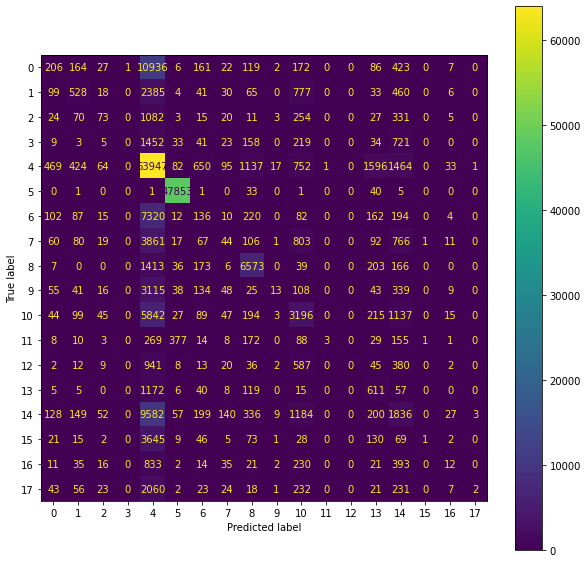

In [100]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(sgd_clf, train_set_X_prepared, train_set_y, ax = ax)

# Multilabel Multioutput Classification

In [101]:
# Include flag and current_service as multilabel classification

In [102]:
df.flag = le.fit_transform(df.flag)

In [103]:
df.head()

,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,hospital_expire_flag,los_admission,gender,...,flag,priority,drg_type,drg_code,drug,route,org_name,test_name,ab_name,curr_service
0,ELECTIVE,Other,HOME,Other,ENGLISH,Other,WHITE,0.0,1.968056,M,...,1,STAT,HCFA,795.0,Other,IM,None,"Blood Culture, Routine",None,5
1,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,0.0,2.222222,F,...,0,ROUTINE,HCFA,442.0,Influenza Vaccine Quadrivalent,IM,None,Other,None,4
2,ELECTIVE,Other,HOME,Other,ENGLISH,Other,ASIAN,0.0,1.865278,F,...,1,STAT,HCFA,795.0,Erythromycin 0.5% Ophth Oint,BOTH EYES,None,Other,None,5
3,EU OBSERVATION,EMERGENCY ROOM,Other,Other,ENGLISH,SINGLE,WHITE,0.0,0.298611,F,...,1,OTHER,OTHER,0.0,None,None,None,None,None,4
4,ELECTIVE,Other,HOME,Other,ENGLISH,Other,WHITE,0.0,4.109722,M,...,1,STAT,HCFA,795.0,Erythromycin 0.5% Ophth Oint,BOTH EYES,None,None,None,5


In [104]:
categorical_columns = df.select_dtypes(include=['string']).columns.tolist()
#categorical_columns.remove('curr_service')
categorical_columns

['admission_type',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'ethnicity',
 'gender',
 'eventtype',
 'priority',
 'drg_type',
 'drug',
 'route',
 'org_name',
 'test_name',
 'ab_name']

In [105]:
numerical_columns = df.select_dtypes(exclude=['string']).columns.tolist()[1:3]
numerical_columns

['los_admission', 'anchor_age']

In [106]:
num_attribs = numerical_columns
cat_attribs = categorical_columns

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OrdinalEncoder(), cat_attribs),
    ])

In [107]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["flag"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [108]:
train_set_X = strat_train_set.drop(["flag", "curr_service"], axis = 1)
train_set_y = strat_train_set[["flag", "curr_service"]].to_numpy()

test_set_X = strat_test_set.drop(["flag", "curr_service"], axis = 1)
test_set_y = strat_test_set[["flag", "curr_service"]].to_numpy()

In [109]:
train_set_X_prepared = full_pipeline.fit_transform(train_set_X)

In [110]:
test_set_X_prepared = full_pipeline.fit_transform(test_set_X)

In [111]:
train_set_y

array([[1, 4],
       [1, 6],
       [1, 5],
       ...,
       [1, 5],
       [1, 0],
       [1, 4]])

In [112]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(train_set_X_prepared, train_set_y)

KNeighborsClassifier()

In [113]:
knn_clf.predict([train_set_X_prepared[52]])

array([[ 1, 10]])

In [115]:
y_train_knn_pred = cross_val_predict(knn_clf, train_set_X_prepared, train_set_y, cv=3)

In [119]:
y_train_knn_pred

array([[1, 4],
       [1, 2],
       [1, 5],
       ...,
       [1, 5],
       [1, 4],
       [1, 4]])

In [120]:
train_set_y

array([[1, 4],
       [1, 6],
       [1, 5],
       ...,
       [1, 5],
       [1, 0],
       [1, 4]])